In [3]:
import warnings

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

In [118]:
params = {'n_estimators': [300, 400, 500, 600, 700],
              'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'max_depth': [3, 4, 5, 6],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'min_child_weight': [1, 2, 3, 4, 5]}

seed = 42
st_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc_scores(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    recall_0, recall_1 = recall_score(y_test, y_pred, pos_label=0), recall_score(y_test, y_pred, pos_label=1)
    precision_0, precision_1 =  precision_score(y_test, y_pred, pos_label=0), precision_score(y_test, y_pred, pos_label=1)
    acc = balanced_accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    arr = np.array([[acc, precision_0, recall_0, precision_1, recall_1,auc_score]])
    return pd.DataFrame(data=arr, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])

def recall_0(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

def precision_0(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)

scoring = {"balanced_accuracy": make_scorer(balanced_accuracy_score),
           "recall_0": make_scorer(recall_0), "precision_0": make_scorer(precision_0),
           "recall_1": make_scorer(recall_score), "precision_1": make_scorer(precision_score), "auc": "roc_auc" }

#cross_validation

def print_score_comparison(raw_score, emb_score, target_feature="posOutcome",
                           header_1="Raw Score", header_2="Embedding Score"):
    print("\t\t{0}\n\t\t\t{1}\t\t{2}".format(target_feature, header_1, header_2))
    print("\t\t-------------------------------------------------------")
    print("balanced_accuracy:\t{0:.2%}\t\t\t\t{1:.2%}\n".format(raw_score["balanced_accuracy"].mean(), emb_score["balanced_accuracy"].mean()))
    print("recall_0:\t\t{0:.2%}\t\t\t\t{1:.2%}\n".format(raw_score["recall_0"].mean(), emb_score["recall_0"].mean()))
    print("precision_0:\t\t{0:.2%}\t\t\t\t{1:.2%}\n".format(raw_score["precision_0"].mean(), emb_score["precision_0"].mean()))
    print("recall_1:\t\t{0:.2%}\t\t\t\t{1:.2%}\n".format(raw_score["recall_1"].mean(), emb_score["recall_1"].mean()))
    print("precision_1:\t\t{0:.2%}\t\t\t\t{1:.2%}\n".format(raw_score["precision_1"].mean(), emb_score["precision_1"].mean()))
    print("auc:\t\t\t{0:.2%}\t\t\t\t{1:.2%}\n".format(raw_score["auc"].mean(), emb_score["auc"].mean()))

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time

    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

def param_tuning(X, y, n_folds=5, param_comb=25, scoring='roc_auc', jobs=12):
    xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    rand_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring=scoring, n_jobs=jobs,
                                   cv=skf.split(X, y), verbose=3, random_state=42)

    start_time = timer(None) # timing starts from this point for "start_time" variable
    rand_search.fit(X, y)
    timer(start_time)
    print("Best Score: {:.3%}".format(rand_search.best_score_))
    print(rand_search.best_params_)
    return rand_search

score_cols = ["test_balanced_accuracy","test_precision_0", "test_recall_0",
               "test_precision_1","test_recall_1", "test_auc"]

def get_scores(cv_results, score_keys=None, df_cols=None):
    if score_keys is None:
        score_keys = score_cols
    if df_cols is None:
        score_keys = score_cols
    scores = np.empty([1, len(score_keys)])
    for i, s in enumerate(score_keys):
        scores[0][i] = np.mean(cv_results[s])
    scores_df = pd.DataFrame(data=scores, columns=df_cols)
    return scores_df

def evaluate_embedding(path, outcome_df, target="posOutcome", merge_col="patient_ID", n_jobs=-1):
    emb_df = pd.read_csv(path, sep="\t")
    emb_outcome_df = pd.merge(outcome_df, emb_df, on=merge_col)
    X_emb, y_emb = emb_outcome_df[emb_outcome_df.columns.difference([merge_col, target])], emb_outcome_df[target]
    X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_emb, y_emb, test_size=0.3, random_state=seed)
    rand_search_emb = param_tuning(X_train_emb, y_train_emb, jobs=n_jobs)
    params = rand_search_emb.best_params_
    clf_emb = rand_search_emb.best_estimator_
    cv_res = cross_validate(clf_emb, X_train_emb, y_train_emb, scoring=scoring, n_jobs=n_jobs, verbose=1, return_train_score=True,
                            cv=st_cv)
    cv_res_df = get_scores(cv_res)
    clf_emb.fit(X_train_emb, y_train_emb)
    test_scores_df = calc_scores(clf_emb, X_test_emb, y_test_emb)

    return params, cv_res_df, test_scores_df

def load_features(path):
    feats = []
    with open(path, "r") as fp:
        for line in fp.readlines():
            feats.append(line.strip())

    return feats
def evaluate_ge(x_train, y_train, x_test, y_test, outcome_cols=None, feats=None, jobs=-1,
                params=None, scoring=scoring, rand_scoring="roc_auc", target="posOutcome"):
    if feats is not None:
        if outcome_cols is not None:
            cols = outcome_cols + feats
        else:
            cols = feats
        x_train = x_train[cols]
        x_test = x_test[cols]
    if params is None:
        rand_search = param_tuning(x_train, y_train, scoring=rand_scoring, jobs=jobs)
        clf_params = rand_search.best_params_
    else:
        clf_params = params
    clf = XGBClassifier(**clf_params)
    cv_res = cross_validate(clf, x_train, y_train,scoring=scoring, cv=st_cv, n_jobs=jobs)

    cv_res_df = get_scores(cv_res, score_cols, df_cols=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
    clf.fit(x_train, y_train)
    test_scores_df = calc_scores(clf, x_test, y_test)

    if params is None:
        return params, clf, cv_res_df, test_scores_df
    else:
        return clf, cv_res_df, test_scores_df

def discretize_dataset(X, features, bins_labels = None):
    if bins_labels is None:
	    bins_labels = [-1, 0, 1]
    X_disc = X[features]
    bin_dict = {}

    for ft in features:
        r1 = X_disc[ft].mean() - X_disc[ft].std() / 2
        r2 = X_disc[ft].mean() + X_disc[ft].std() / 2
        bin_dict[ft]= [-np.inf, r1, r2, np.inf]
    le = LabelEncoder()

    le.fit(bins_labels)

    for ft in bin_dict:
        X_disc[ft] = le.transform(pd.cut(X_disc[ft], bins=bin_dict[ft], labels=bins_labels))

    ohe = OneHotEncoder(handle_unknown="ignore")
    transformed = ohe.fit_transform(X_disc).toarray()
    X_disc = pd.DataFrame(transformed, columns=ohe.get_feature_names(features))
    return X_disc
def optimize_k_v1(df, target, exclude=None):
    if exclude is None:
        exclude = ["patient_ID"]
    df = df.drop(exclude, axis=1)
    data = df.to_numpy()
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)

        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})

    return errors

from sklearn.metrics import mean_squared_error as rmse
def optimize_k_v2(X, y):
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(X)
        df_imputed = pd.DataFrame(imputed, columns=X.columns)
        X_train, X_test, y_train, y_test = train_test_split(df_imputed, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier()
        model.fit(X_train.values, y_train.values)
        preds = model.predict(X_test.values)
        error = rmse(y_test.values, preds)
        errors.append({'K': k, 'RMSE': error})

    least_err = sorted(errors, key=lambda k: k["RMSE"])[0]
    print("Got least RMSE {0:.2f} at n={1}".format(least_err["RMSE"],
                                                   least_err["K"]))

    return least_err["K"]

def impute_dataset_v1(df, imputer, target="posOutcome",
                   drop_target=True):
    if drop_target:
        X = df.drop([target], axis=1)
    else:
        X = df
    X_new = imputer.fit_transform(X)
    df_imputed = pd.DataFrame(X_new, columns=X.columns, index=X.index)
    print("Shape imputed: " + str(df_imputed.shape))
    if drop_target:
        p_outcome_df = df["posOutcome"]
        df_imputed = pd.concat([p_outcome_df, df_imputed], axis=1,
                    verify_integrity=True)
        print("Shape imputed concat: " + str(df_imputed.shape))
    return df_imputed

def impute_knn(X, y):
    n = optimize_k_v2(X, y)
    imputer = KNNImputer(n_neighbors=n)
    X_new = imputer.fit_transform(X)
    df_imputed = pd.DataFrame(X_new, columns=X.columns, index=X.index)
    return df_imputed

def one_hot_encode(df, cat_features):
    X_cats = df[cat_features]
    ohe = OneHotEncoder(dtype=np.int64)
    X_ohe = ohe.fit_transform(X_cats).toarray()
    fts_names = ohe.get_feature_names(cat_features)
    ohe_df = pd.DataFrame(X_ohe, columns=fts_names, index=X_cats.index)
    non_cat_df = df[df.columns.difference(cat_features)]
    df_encoded = pd.concat([non_cat_df, ohe_df], axis=1, verify_integrity=True)
    return df_encoded

def find_diff(df1, df2, index="patient_ID"):
    def highlight_diff(data, color='yellow'):
        attr = 'background-color: {}'.format(color)
        other = data.xs('First', axis='columns', level=-1)
        return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                            index=data.index, columns=data.columns)

    df_all = pd.concat([df1.set_index(index), df2.set_index(index)],
                   axis='columns', keys=['First', 'Second'])
    df_final = df_all.swaplevel(axis='columns')[df1.columns[1:]]
    df_final.style.apply(highlight_diff, axis=None)
    return df_final

In [5]:
#Load the datasets

ge_df = pd.read_csv("datasets/merged-combat15.csv", index_col="patient_ID")
state_df = pd.read_csv("datasets/state_and_outcome.csv", index_col="patient_ID")
state_df

,series_id,gpl,channel_count,RFS,DFS,pCR,ER,HER2,PR,node,tumor,pam_coincide,p5,posOutcome,posOutcome2
patient_ID,,,,,,,,,,,,,,,
809184,GSE32646,GPL570,1,NaN,NaN,0.0,1.0,0.0,0.0,1.0,T3,LumB,k5,0,NaN
809185,GSE32646,GPL570,1,NaN,NaN,1.0,0.0,0.0,0.0,1.0,T3,LumB,k5,1,NaN
809186,GSE32646,GPL570,1,NaN,NaN,0.0,0.0,0.0,0.0,1.0,T3,Her2,k3,0,NaN
809187,GSE32646,GPL570,1,NaN,NaN,0.0,1.0,1.0,1.0,1.0,T3,LumB,k5,0,NaN
809188,GSE32646,GPL570,1,NaN,NaN,0.0,1.0,0.0,1.0,1.0,T2,Basal,k1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491199,GSE19615,GPL570,1,1.0,NaN,NaN,0.0,0.0,0.0,0.0,T2,Basal,k2,1,1.0
491270,GSE19615,GPL570,1,1.0,NaN,NaN,1.0,1.0,1.0,0.0,T2,LumB,k5,1,1.0
491200,GSE19615,GPL570,1,1.0,NaN,NaN,0.0,1.0,0.0,1.0,T2,Her2,k2,1,1.0


In [6]:
#Feature engineering

state_df = state_df.drop(["series_id", "channel_count", "RFS", "DFS",
                          "pCR", "posOutcome2"], axis=1)

In [117]:
gpl_vals = state_df["gpl"].unique()
print(gpl_vals)
pam_subtypes = state_df["pam_coincide"].unique()
print(pam_subtypes)
p5_types = state_df["p5"].unique()
print(p5_types)
tumor_types = state_df["tumor"].unique()
print(tumor_types)

<IntegerArray>
[0, 5, 2, 4, 1, 3]
Length: 6, dtype: Int64
<IntegerArray>
[2, 1, 4, 3, 0]
Length: 5, dtype: Int64
<IntegerArray>
[0, 1, 2, 3, 4]
Length: 5, dtype: Int64
<IntegerArray>
[2, 1, 3, 4, <NA>, 0]
Length: 6, dtype: Int64


In [8]:
#Drop the 12 patients with pam_coincide or p5 null
state_df = state_df.dropna(axis=0, subset=["pam_coincide", "p5"])
state_df.shape

(2225, 9)

In [9]:
#label encode each non-null value [Fixes the tumor -1 issue]
state_df = state_df.apply(lambda col: pd.Series(
    LabelEncoder().fit_transform(col[col.notnull()]),
    index=col[col.notnull()].index))

state_df.dtypes

gpl               int64
ER              float64
HER2            float64
PR              float64
node            float64
tumor           float64
pam_coincide      int64
p5                int64
posOutcome        int64
dtype: object

In [66]:
#Change the dataframe features to int
#Note using "Int64" instead of np.int64 because NaN values
# can't be converted to int by default
#See https://stackoverflow.com/q/11548005/3380414
for col in state_df.columns:
    state_df[col] = state_df[col].astype("Int64")

state_df.dtypes

gpl             Int64
ER              Int64
HER2            Int64
PR              Int64
node            Int64
tumor           Int64
pam_coincide    Int64
p5              Int64
posOutcome      Int64
dtype: object

In [43]:
#With and without posoutcome test
knn_imputer = KNNImputer(n_neighbors=9) #Got n=9 from previous whole dataset knn optimization
state_df_v2a = impute_dataset_v1(state_df, knn_imputer, drop_target=False)
state_df_v2b = impute_dataset_v1(state_df, knn_imputer, drop_target=True)
state_df_2a = state_df_v2a.drop(["gpl"], axis=1)
state_df_v2b = state_df_v2b.drop(["gpl"], axis=1)
##KNN imputer changes its input to float so we should change them back to int
state_df_v2a = state_df_2a.astype(np.int64)
state_df_v2b = state_df_v2b.astype(np.int64)
state_df_v2a = one_hot_encode(state_df_v2a, ["pam_coincide", "p5"])
state_df_v2b = one_hot_encode(state_df_v2b, ["pam_coincide", "p5"])

Shape imputed: (2225, 9)
Shape imputed: (2225, 8)
Shape imputed concat: (2225, 9)


In [44]:
#Patient id=125165 had tumor value NA
state_df_v2a.loc[125165]

ER                1
HER2              0
PR                0
node              0
posOutcome        1
tumor             1
pam_coincide_0    0
pam_coincide_1    0
pam_coincide_2    1
pam_coincide_3    0
pam_coincide_4    0
p5_0              0
p5_1              0
p5_2              1
p5_3              0
p5_4              0
Name: 125165, dtype: int64

In [45]:
state_df_v2b.loc[125165]

ER                1
HER2              0
PR                0
node              0
posOutcome        1
tumor             1
pam_coincide_0    0
pam_coincide_1    0
pam_coincide_2    1
pam_coincide_3    0
pam_coincide_4    0
p5_0              0
p5_1              0
p5_2              1
p5_3              0
p5_4              0
Name: 125165, dtype: int64

In [46]:
X_st_v2a, y_st_v2a = state_df_v2a.drop(["posOutcome"], axis=1), state_df_v2a["posOutcome"]
X_st_v2a_train, X_st_v2a_test, y_st_v2a_train, y_st_v2a_test = train_test_split(X_st_v2a, y_st_v2a,                                            test_size=0.3, random_state=seed, stratify=y_st_v2a)

In [47]:
params_st_v2a, clf_st_v2a, cv_scores_st_v2a, test_scores_st_v2a = evaluate_ge(
    X_st_v2a_train, y_st_v2a_train, X_st_v2a_test, y_st_v2a_test)
print(params_st_v2a)
cv_scores_st_v2a.mean()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:05:02] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:05:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 2 minutes and 11.41 seconds.
Best Score: 80.007%
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.07, 'gamma': 1.5, 'colsample_bytree': 0.6}
[21:06:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was c

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.2min finished


balanced_accuracy    0.723393
recall_0             0.713682
precision_0          0.805813
recall_1             0.749411
precision_1          0.640973
auc                  0.800070
dtype: float64

In [48]:
test_scores_st_v2a.mean()

balanced_accuracy    0.703107
recall_0             0.694789
precision_0          0.795455
recall_1             0.728302
precision_1          0.610759
auc                  0.784702
dtype: float64

In [49]:
X_st_v2b, y_st_v2b = state_df_v2b.drop(["posOutcome"], axis=1), state_df_v2b["posOutcome"]
X_st_v2b_train, X_st_v2b_test, y_st_v2b_train, y_st_v2b_test = train_test_split(X_st_v2b, y_st_v2b,                                            test_size=0.3, random_state=seed, stratify=y_st_v2b)

In [50]:
params_st_v2b, clf_st_v2b, cv_scores_st_v2b, test_scores_st_v2b = evaluate_ge(
    X_st_v2b_train, y_st_v2b_train, X_st_v2b_test, y_st_v2b_test)
print(params_st_v2b)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:08:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 5.8 seconds.
Best Score: 74.564%
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 2, 'colsample_bytree': 0.6}
[21:09:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    5.5s finished


In [52]:
print("CV Score: \n{0}\n".format(cv_scores_st_v2b.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_v2b.mean()))


CV Score: 
balanced_accuracy    0.675596
recall_0             0.670502
precision_0          0.776582
recall_1             0.699788
precision_1          0.574609
auc                  0.745640
dtype: float64

Test Score:
balanced_accuracy    0.646055
recall_0             0.647643
precision_0          0.741477
recall_1             0.656604
precision_1          0.550633
auc                  0.724265
dtype: float64



In [53]:
print_score_comparison(test_scores_st_v2a, test_scores_st_v2b, header_1="KNN w/ PosOutcome", header_2="KNN W/o posOutcome")

		posOutcome
			KNN w/ PosOutcome		KNN W/o posOutcome
		-------------------------------------------------------
balanced_accuracy:	70.31%				64.61%

recall_0:		69.48%				64.76%

precision_0:		79.55%				74.15%

recall_1:		72.83%				65.66%

precision_1:		61.08%				55.06%

auc:			78.47%				72.43%



In [89]:
X_v3, y_v3 = state_df.drop(["posOutcome"], axis=1), state_df["posOutcome"]
X_v3a_train, X_v3a_test, y_v3a_train, y_v3a_test = train_test_split(X_v3, y_v3, test_size=0.3, random_state=seed, stratify=y_v3)
y_v3a_train, y_v3a_test = y_v3a_train.astype(np.int64), y_v3a_test.astype(np.int64)
X_v3a_train = impute_knn(X_v3a_train, y_v3a_train)
X_v3a_train

Got least RMSE 0.28 at n=13


,gpl,ER,HER2,PR,node,tumor,pam_coincide,p5
patient_ID,,,,,,,,
809258,4.0,1.0,1.000000,1.000000,0.0,2.000000,1.0,3.0
411352,4.0,0.0,0.000000,0.230769,0.0,1.000000,0.0,3.0
441648,5.0,1.0,0.076923,0.538462,0.0,1.615385,1.0,0.0
615633,5.0,1.0,0.000000,1.000000,1.0,2.000000,2.0,3.0
36900,5.0,1.0,0.000000,0.000000,0.0,2.000000,0.0,4.0
...,...,...,...,...,...,...,...,...
441664,5.0,1.0,0.000000,0.846154,0.0,2.000000,2.0,1.0
249566,2.0,1.0,0.076923,1.000000,0.0,2.000000,3.0,2.0
505360,5.0,0.0,0.000000,0.000000,1.0,3.000000,0.0,1.0


In [90]:
X_v3a_train = X_v3a_train.astype(np.int64)
X_v3a_train = one_hot_encode(X_v3a_train, ["pam_coincide", "p5"])
X_v3a_train = X_v3a_train.drop(["gpl"], axis=1)

In [91]:
X_v3a_test

,gpl,ER,HER2,PR,node,tumor,pam_coincide,p5
patient_ID,,,,,,,,
441878,5,1,<NA>,<NA>,1,<NA>,2,1
508192,1,0,0,0,<NA>,3,0,1
615203,5,1,0,1,1,3,2,2
36884,5,1,<NA>,1,0,1,3,0
615197,5,0,0,0,1,2,3,1
...,...,...,...,...,...,...,...,...
441799,5,1,<NA>,<NA>,0,<NA>,3,3
505475,5,0,0,0,0,1,4,0
411277,4,1,<NA>,1,1,<NA>,2,4


In [92]:
knn_imputer_2 = KNNImputer(n_neighbors=13)
X_tmp = knn_imputer_2.fit_transform(X_v3a_test)
X_v3a_test = pd.DataFrame(X_tmp, columns=X_v3a_test.columns, index=X_v3a_test.index)
X_v3a_test = X_v3a_test.astype(np.int64)
X_v3a_test = one_hot_encode(X_v3a_test, ["pam_coincide", "p5"])
X_v3a_test = X_v3a_test.drop(["gpl"], axis=1)
X_v3a_test

,ER,HER2,PR,node,tumor,pam_coincide_0,pam_coincide_1,pam_coincide_2,pam_coincide_3,pam_coincide_4,p5_0,p5_1,p5_2,p5_3,p5_4
patient_ID,,,,,,,,,,,,,,,
441878,1,0,0,1,2,0,0,1,0,0,0,1,0,0,0
508192,0,0,0,0,3,1,0,0,0,0,0,1,0,0,0
615203,1,0,1,1,3,0,0,1,0,0,0,0,1,0,0
36884,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0
615197,0,0,0,1,2,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441799,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
505475,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
411277,1,0,1,1,1,0,0,1,0,0,0,0,0,0,1


In [93]:
params_st_v3a, clf_st_v3a, cv_scores_st_v3a, test_scores_st_v3a = evaluate_ge(
    X_v3a_train, y_v3a_train, X_v3a_test, y_v3a_test)
print(params_st_v3a)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:34:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 6.93 seconds.
Best Score: 74.238%
{'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6}
[21:35:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chan

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    6.7s finished


In [94]:
print("CV Score: \n{0}\n".format(cv_scores_st_v3a.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_v3a.mean()))


CV Score: 
balanced_accuracy    0.677099
recall_0             0.675757
precision_0          0.761911
recall_1             0.693331
precision_1          0.592287
auc                  0.742381
dtype: float64

Test Score:
balanced_accuracy    0.627877
recall_0             0.632099
precision_0          0.727273
recall_1             0.634981
precision_1          0.528481
auc                  0.701102
dtype: float64



In [95]:
X_v3b_train, X_v3b_test, y_v3b_train, y_v3b_test = train_test_split(X_v3, y_v3, test_size=0.3, random_state=seed)
y_v3b_train, y_v3b_test = y_v3b_train.astype(np.int64), y_v3b_test.astype(np.int64)
X_v3b_train = impute_knn(X_v3b_train, y_v3b_train)
X_v3b_train

Got least RMSE 0.29 at n=13


,gpl,ER,HER2,PR,node,tumor,pam_coincide,p5
patient_ID,,,,,,,,
508280,1.0,0.0,1.000000,0.000000,0.692308,3.000000,1.0,3.0
508586,3.0,0.0,1.000000,0.000000,0.846154,2.000000,1.0,1.0
508328,1.0,1.0,1.000000,1.000000,0.615385,3.000000,2.0,1.0
491246,4.0,1.0,0.000000,1.000000,1.000000,1.000000,2.0,3.0
305255,5.0,1.0,0.000000,0.846154,0.538462,2.076923,3.0,3.0
...,...,...,...,...,...,...,...,...
508327,1.0,1.0,1.000000,1.000000,0.384615,2.000000,1.0,3.0
441867,5.0,1.0,0.153846,0.769231,0.000000,1.923077,2.0,1.0
441902,5.0,1.0,0.000000,0.923077,1.000000,2.076923,2.0,3.0


In [96]:
X_v3b_train = X_v3b_train.astype(np.int64)
X_v3b_train = one_hot_encode(X_v3b_train, ["pam_coincide", "p5"])
X_v3b_train = X_v3b_train.drop(["gpl"], axis=1)

In [97]:
X_v3b_test

,gpl,ER,HER2,PR,node,tumor,pam_coincide,p5
patient_ID,,,,,,,,
249541,2,1,<NA>,0,1,1,2,1
249547,2,1,<NA>,1,1,2,2,1
508334,1,1,0,1,<NA>,2,2,3
249543,2,1,<NA>,1,1,2,3,1
491257,4,1,0,1,1,2,2,3
...,...,...,...,...,...,...,...,...
441847,5,1,<NA>,<NA>,1,<NA>,0,0
615687,5,0,0,0,0,3,4,0
305158,5,1,<NA>,<NA>,<NA>,<NA>,2,4


In [98]:
knn_imputer_2 = KNNImputer(n_neighbors=13)
X_tmp = knn_imputer_2.fit_transform(X_v3b_test)
X_v3b_test = pd.DataFrame(X_tmp, columns=X_v3b_test.columns, index=X_v3b_test.index)
X_v3b_test = X_v3b_test.astype(np.int64)
X_v3b_test = one_hot_encode(X_v3b_test, ["pam_coincide", "p5"])
X_v3b_test = X_v3b_test.drop(["gpl"], axis=1)
X_v3b_test

,ER,HER2,PR,node,tumor,pam_coincide_0,pam_coincide_1,pam_coincide_2,pam_coincide_3,pam_coincide_4,p5_0,p5_1,p5_2,p5_3,p5_4
patient_ID,,,,,,,,,,,,,,,
249541,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0
249547,1,0,1,1,2,0,0,1,0,0,0,1,0,0,0
508334,1,0,1,0,2,0,0,1,0,0,0,0,0,1,0
249543,1,0,1,1,2,0,0,0,1,0,0,1,0,0,0
491257,1,0,1,1,2,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441847,1,0,0,1,2,1,0,0,0,0,1,0,0,0,0
615687,0,0,0,0,3,0,0,0,0,1,1,0,0,0,0
305158,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [99]:
params_st_v3b, clf_st_v3b, cv_scores_st_v3b, test_scores_st_v3b = evaluate_ge(
    X_v3b_train, y_v3b_train, X_v3b_test, y_v3b_test)
print(params_st_v3b)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:37:41] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:37:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 5.9 seconds.
Best Score: 72.531%
{'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 2, 'colsample_bytree': 0.6}
[21:38:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    5.5s finished


In [100]:
print("CV Score: \n{0}\n".format(cv_scores_st_v3b.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_v3b.mean()))

CV Score: 
balanced_accuracy    0.660654
recall_0             0.661580
precision_0          0.754538
recall_1             0.672883
precision_1          0.566769
auc                  0.725315
dtype: float64

Test Score:
balanced_accuracy    0.662428
recall_0             0.649289
precision_0          0.787356
recall_1             0.699187
precision_1          0.537500
auc                  0.740270
dtype: float64



In [101]:
print_score_comparison(cv_scores_st_v3a, cv_scores_st_v3b, header_1="Stratified KNN", header_2="Not Stratified KNN")

		posOutcome
			Stratified KNN		Not Stratified KNN
		-------------------------------------------------------
balanced_accuracy:	67.71%				66.07%

recall_0:		67.58%				66.16%

precision_0:		76.19%				75.45%

recall_1:		69.33%				67.29%

precision_1:		59.23%				56.68%

auc:			74.24%				72.53%



In [102]:
print_score_comparison(test_scores_st_v3a, test_scores_st_v3b, header_1="Stratified KNN", header_2="Not Stratified KNN")

		posOutcome
			Stratified KNN		Not Stratified KNN
		-------------------------------------------------------
balanced_accuracy:	62.79%				66.24%

recall_0:		63.21%				64.93%

precision_0:		72.73%				78.74%

recall_1:		63.50%				69.92%

precision_1:		52.85%				53.75%

auc:			70.11%				74.03%



In [103]:
X_v3b_train.to_csv("datasets/train_st_knn.csv")
X_v3a_test.to_csv("datasets/test_st_knn.csv")

In [112]:
sim_imputer_1 = SimpleImputer(strategy="constant", fill_value=0)
X_tmp = state_df.drop(["posOutcome"], axis=1)
X_new = sim_imputer_1.fit_transform(X_tmp)
state_df_v4 = pd.DataFrame(X_new, columns=X_tmp.columns, index=X_tmp.index)
state_df_v4 = state_df_v4.astype(np.int64)
state_df_v4 = state_df_v4.drop(["gpl"], axis=1)
state_df_v4 = one_hot_encode(state_df_v4, ["pam_coincide", "p5"])
X_st_v4, y_st_v4 = state_df_v4, state_df["posOutcome"]
X_st_v4_train, X_st_v4_test, y_st_v4_train, y_st_v4_test = train_test_split(X_st_v4, y_st_v4, test_size=0.3, random_state=seed)
y_st_v4_train, y_st_v4_test = y_st_v4_train.astype(np.int64), y_st_v4_test.astype(np.int64)
X_st_v4_train.to_csv("datasets/train_st_sim.csv")
X_st_v4_test.to_csv("datasets/test_st_sim.csv")

In [113]:
params_st_v4, clf_st_v4, cv_scores_st_v4, test_scores_st_v4 = evaluate_ge(
    X_st_v4_train, y_st_v4_train, X_st_v4_test, y_st_v4_test)

print(params_st_v4)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[23:40:01] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:40:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 6.99 seconds.
Best Score: 77.150%
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 2, 'colsample_bytree': 0.6}
[23:40:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chan

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    6.7s finished


In [114]:
print("CV Score: \n{0}\n".format(cv_scores_st_v4.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_v4.mean()))


CV Score: 
balanced_accuracy    0.703887
recall_0             0.704349
precision_0          0.771552
recall_1             0.712634
precision_1          0.636222
auc                  0.771502
dtype: float64

Test Score:
balanced_accuracy    0.717619
recall_0             0.712401
precision_0          0.775862
recall_1             0.730104
precision_1          0.659375
auc                  0.778587
dtype: float64



In [115]:
print_score_comparison(test_scores_st_v3b, test_scores_st_v4, header_1="State KNN", header_2="State Simple")

		posOutcome
			State KNN		State Simple
		-------------------------------------------------------
balanced_accuracy:	66.24%				71.76%

recall_0:		64.93%				71.24%

precision_0:		78.74%				77.59%

recall_1:		69.92%				73.01%

precision_1:		53.75%				65.94%

auc:			74.03%				77.86%



In [ ]:
state_df_v5 = state_df[state_df.notnull().any(axis=1)]

In [132]:
X_st_v3_ge_train = pd.merge(X_v3b_train, ge_df, left_index=True, right_index=True)
y_st_v3_ge_train = pd.Series(y_v3b_train, index=X_st_v3_ge_train.index)
X_st_v3_ge_test = pd.merge(X_v3b_test, ge_df, left_index=True, right_index=True)
y_st_v3_ge_test = pd.Series(y_v3b_test, index=X_st_v3_ge_test.index)
ft_mrmr50 = load_features("datasets/mrmr_ft50.txt")
X_st_v3_ge_train = X_st_v3_ge_train[ft_mrmr50]
X_st_v3_ge_test = X_st_v3_ge_test[ft_mrmr50]

In [136]:
params_st_v3_ge, clf_st_v3_ge, cv_scores_st_v3_ge, test_scores_st_v3_ge = evaluate_ge(
    X_st_v3_ge_train, y_st_v3_ge_train, X_st_v3_ge_test, y_st_v3_ge_test)
print(params_st_v3_ge)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[12:41:04] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:41:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 24.06 seconds.
Best Score: 82.864%
{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 5, 'colsample_bytree': 0.6}
[12:42:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was cha

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   22.6s finished


In [137]:
print("CV Score: \n{0}\n".format(cv_scores_st_v3_ge.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_v3_ge.mean()))

CV Score: 
balanced_accuracy    0.768114
recall_0             0.788003
precision_0          0.767857
recall_1             0.747643
precision_1          0.768372
auc                  0.828639
dtype: float64

Test Score:
balanced_accuracy    0.767870
recall_0             0.781341
precision_0          0.770115
recall_1             0.753846
precision_1          0.765625
auc                  0.819774
dtype: float64



In [150]:
X_st_v4_ge_train = pd.merge(X_st_v4_train, ge_df, left_index=True, right_index=True)
y_st_v4_ge_train = pd.Series(y_st_v4_train ,index=X_st_v4_ge_train.index)
X_st_v4_ge_test = pd.merge(X_st_v4_test, ge_df, left_index=True, right_index=True)
y_st_v4_ge_test = pd.Series(y_st_v4_test, index=X_st_v4_ge_test.index)
X_st_v4_ge_train = X_st_v4_ge_train[ft_mrmr50]
X_st_v4_ge_test = X_st_v4_ge_test[ft_mrmr50]

In [151]:
params_st_v4_ge, clf_st_v4_ge, cv_scores_st_v4_ge, test_scores_st_v4_ge = evaluate_ge(
    X_st_v4_ge_train, y_st_v4_ge_train, X_st_v4_ge_test, y_st_v4_ge_test)
print(params_st_v4_ge)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[14:18:17] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:18:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 23.94 seconds.
Best Score: 82.864%
{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 5, 'colsample_bytree': 0.6}
[14:19:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was cha

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   22.5s finished


In [152]:
print("CV Score: \n{0}\n".format(cv_scores_st_v4_ge.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_v4_ge.mean()))

CV Score: 
balanced_accuracy    0.768114
recall_0             0.788003
precision_0          0.767857
recall_1             0.747643
precision_1          0.768372
auc                  0.828639
dtype: float64

Test Score:
balanced_accuracy    0.767870
recall_0             0.781341
precision_0          0.770115
recall_1             0.753846
precision_1          0.765625
auc                  0.819774
dtype: float64



In [160]:
print_score_comparison(cv_scores_st_v3_ge ,cv_scores_st_v4_ge, header_1="State KNN + MRMR50",
                       header_2="State Simple + MRMR50")

		posOutcome
			State KNN + MRMR50		State Simple + MRMR50
		-------------------------------------------------------
balanced_accuracy:	76.81%				76.81%

recall_0:		78.80%				78.80%

precision_0:		76.79%				76.79%

recall_1:		74.76%				74.76%

precision_1:		76.84%				76.84%

auc:			82.86%				82.86%



In [161]:
print_score_comparison(test_scores_st_v3b ,test_scores_st_v4, header_1="State KNN + MRMR50",
                       header_2="State Simple + MRMR50")

		posOutcome
			State KNN + MRMR50		State Simple + MRMR50
		-------------------------------------------------------
balanced_accuracy:	66.24%				71.76%

recall_0:		64.93%				71.24%

precision_0:		78.74%				77.59%

recall_1:		69.92%				73.01%

precision_1:		53.75%				65.94%

auc:			74.03%				77.86%



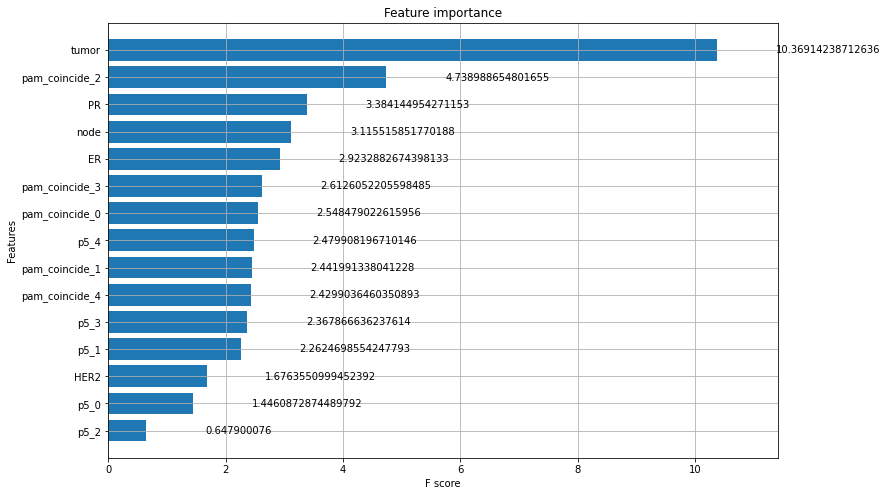

In [165]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(clf_st_v3b, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

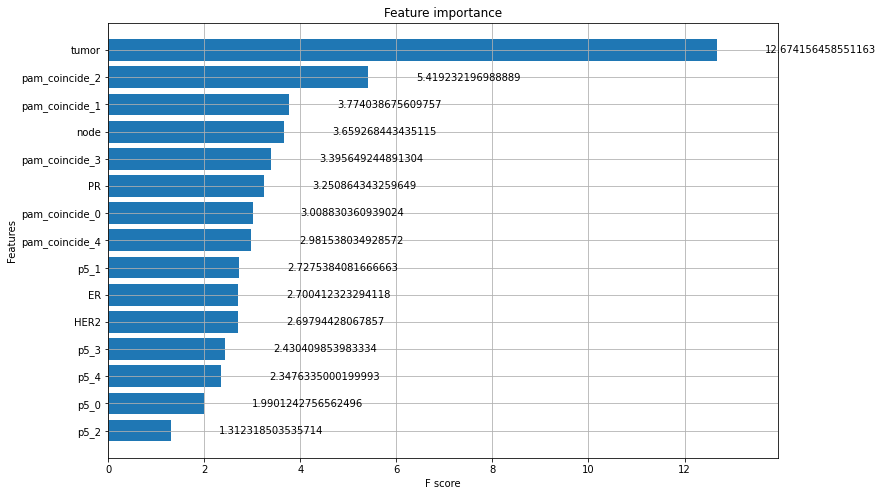

In [166]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(clf_st_v4, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

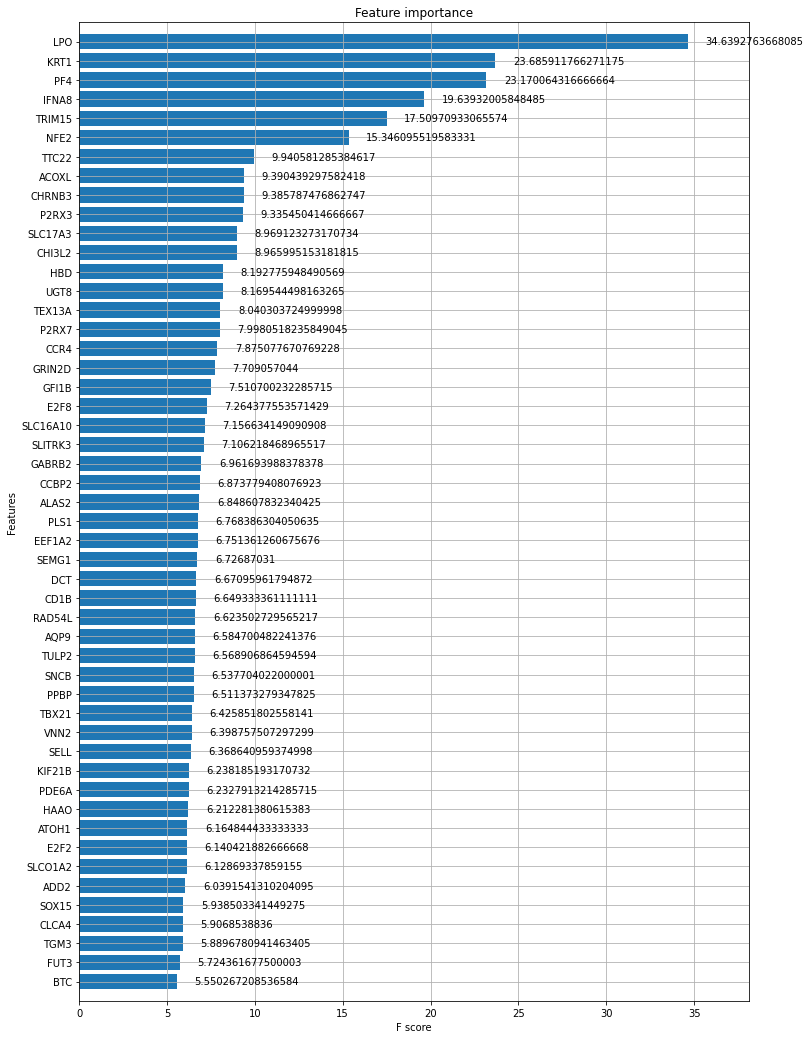

In [168]:
fig, ax = plt.subplots(figsize=(12, 18))
plot_importance(clf_st_v3_ge, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

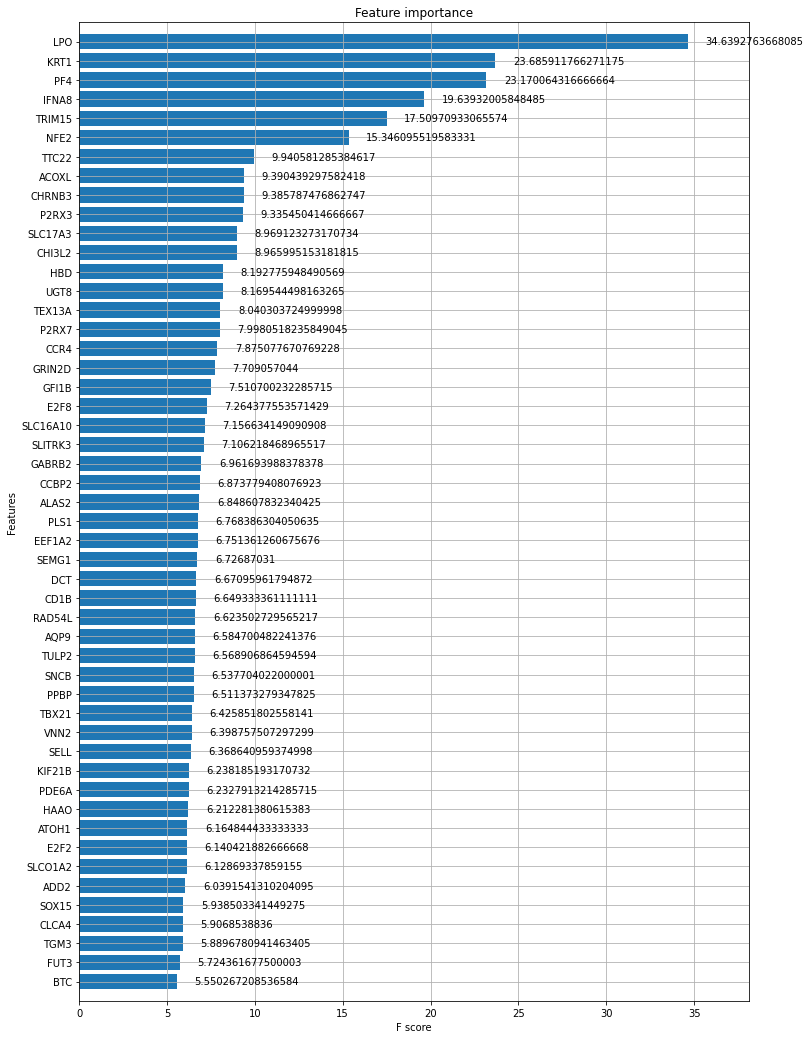

In [169]:
fig, ax = plt.subplots(figsize=(12, 18))
plot_importance(clf_st_v4_ge, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

In [182]:
#Without Pam subtypes
X_st_v5_train, X_st_v5_test = X_v3b_train.loc[:, ~X_v3b_train.columns.str.startswith("pam")], X_v3b_test.loc[:, ~X_v3b_test.columns.str.startswith("pam")]

In [183]:
params_st_5, clf_st_5, cv_scores_st_5, test_scores_st_5 = evaluate_ge(
    X_st_v5_train, y_v3b_train, X_st_v5_test, y_v3b_test)
print(params_st_5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[14:40:01] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:40:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 4.58 seconds.
Best Score: 71.429%
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 2, 'colsample_bytree': 0.6}
[14:40:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chan

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    4.3s finished


In [184]:
print("CV Score: \n{0}\n".format(cv_scores_st_5.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_5.mean()))

CV Score: 
balanced_accuracy    0.649596
recall_0             0.654492
precision_0          0.735181
recall_1             0.655572
precision_1          0.564011
auc                  0.714290
dtype: float64

Test Score:
balanced_accuracy    0.661997
recall_0             0.654321
precision_0          0.761494
recall_1             0.684411
precision_1          0.562500
auc                  0.729530
dtype: float64



In [185]:
print_score_comparison(cv_scores_st_v3b, cv_scores_st_5, header_1="With PAM", header_2="Without PAM")

		posOutcome
			With PAM		Without PAM
		-------------------------------------------------------
balanced_accuracy:	66.07%				64.96%

recall_0:		66.16%				65.45%

precision_0:		75.45%				73.52%

recall_1:		67.29%				65.56%

precision_1:		56.68%				56.40%

auc:			72.53%				71.43%



In [186]:
print_score_comparison(test_scores_st_v3b, test_scores_st_5, header_1="With PAM", header_2="Without PAM")

		posOutcome
			With PAM		Without PAM
		-------------------------------------------------------
balanced_accuracy:	66.24%				66.20%

recall_0:		64.93%				65.43%

precision_0:		78.74%				76.15%

recall_1:		69.92%				68.44%

precision_1:		53.75%				56.25%

auc:			74.03%				72.95%



In [194]:
#Without p5 class
X_st_v6_train, X_st_v6_test = X_v3b_train.loc[:, ~X_v3b_train.columns.str.startswith("p5")], X_v3b_test.loc[:, ~X_v3b_test.columns.str.startswith("p5")]
X_st_v6_train

,ER,HER2,PR,node,tumor,pam_coincide_0,pam_coincide_1,pam_coincide_2,pam_coincide_3,pam_coincide_4
patient_ID,,,,,,,,,,
508280,0,1,0,0,3,0,1,0,0,0
508586,0,1,0,0,2,0,1,0,0,0
508328,1,1,1,0,3,0,0,1,0,0
491246,1,0,1,1,1,0,0,1,0,0
305255,1,0,0,0,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
508327,1,1,1,0,2,0,1,0,0,0
441867,1,0,0,0,1,0,0,1,0,0
441902,1,0,0,1,2,0,0,1,0,0


In [188]:
params_st_v6, clf_st_v6, cv_scores_st_v6, test_scores_st_v6 = evaluate_ge(
    X_st_v6_train, y_v3b_train, X_st_v6_test, y_v3b_test)
print(params_st_v6)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[14:44:30] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:44:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 4.48 seconds.
Best Score: 72.451%
{'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.6}
[14:45:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chan

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    4.2s finished


In [189]:
print("CV Score: \n{0}\n".format(cv_scores_st_v6.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_v6.mean()))

CV Score: 
balanced_accuracy    0.651579
recall_0             0.649022
precision_0          0.769098
recall_1             0.675032
precision_1          0.534060
auc                  0.724505
dtype: float64

Test Score:
balanced_accuracy    0.661800
recall_0             0.645833
precision_0          0.801724
recall_1             0.707627
precision_1          0.521875
auc                  0.744841
dtype: float64



In [190]:

print_score_comparison(cv_scores_st_v3b, cv_scores_st_v6, header_1="With P5", header_2="Without P5")

		posOutcome
			With P5		Without P5
		-------------------------------------------------------
balanced_accuracy:	66.07%				65.16%

recall_0:		66.16%				64.90%

precision_0:		75.45%				76.91%

recall_1:		67.29%				67.50%

precision_1:		56.68%				53.41%

auc:			72.53%				72.45%



In [191]:
print_score_comparison(test_scores_st_v3b, test_scores_st_v6, header_1="With P5", header_2="Without P5")


		posOutcome
			With P5		Without P5
		-------------------------------------------------------
balanced_accuracy:	66.24%				66.18%

recall_0:		64.93%				64.58%

precision_0:		78.74%				80.17%

recall_1:		69.92%				70.76%

precision_1:		53.75%				52.19%

auc:			74.03%				74.48%



In [195]:
#Without pam and p5
X_st_v7_train, X_st_v7_test = X_st_v6_train.loc[:, ~X_st_v6_train.columns.str.startswith("pam")], X_st_v6_test.loc[:,~X_st_v6_train.columns.str.startswith("pam")]
X_st_v7_train

,ER,HER2,PR,node,tumor
patient_ID,,,,,
508280,0,1,0,0,3
508586,0,1,0,0,2
508328,1,1,1,0,3
491246,1,0,1,1,1
305255,1,0,0,0,2
...,...,...,...,...,...
508327,1,1,1,0,2
441867,1,0,0,0,1
441902,1,0,0,1,2


In [196]:
params_st_v7, clf_st_v7, cv_scores_st_v7, test_scores_st_v7 = evaluate_ge(
    X_st_v7_train, y_v3b_train, X_st_v7_test, y_v3b_test)
print(params_st_v6)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[14:49:24] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 3.26 seconds.
Best Score: 71.023%
{'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.6}
[14:50:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    3.1s finished


In [197]:
print("CV Score: \n{0}\n".format(cv_scores_st_v7.mean()))
print("Test Score:\n{0}\n".format(test_scores_st_v7.mean()))

CV Score: 
balanced_accuracy    0.654215
recall_0             0.658394
precision_0          0.737561
recall_1             0.660789
precision_1          0.570869
auc                  0.710229
dtype: float64

Test Score:
balanced_accuracy    0.664619
recall_0             0.654501
precision_0          0.772989
recall_1             0.692607
precision_1          0.556250
auc                  0.719855
dtype: float64



In [198]:
print_score_comparison(cv_scores_st_v3b, cv_scores_st_v6, header_1="With PAM &P5", header_2="Without PAM & P5")

		posOutcome
			With PAM &P5		Without PAM & P5
		-------------------------------------------------------
balanced_accuracy:	66.07%				65.16%

recall_0:		66.16%				64.90%

precision_0:		75.45%				76.91%

recall_1:		67.29%				67.50%

precision_1:		56.68%				53.41%

auc:			72.53%				72.45%



In [199]:
print_score_comparison(test_scores_st_v3b, test_scores_st_v6, header_1="With PAM & P5", header_2="Without PAM & P5")

		posOutcome
			With PAM & P5		Without PAM & P5
		-------------------------------------------------------
balanced_accuracy:	66.24%				66.18%

recall_0:		64.93%				64.58%

precision_0:		78.74%				80.17%

recall_1:		69.92%				70.76%

precision_1:		53.75%				52.19%

auc:			74.03%				74.48%



In [221]:
state_df["posOutcome"] = state_df["posOutcome"].astype(np.int64)
null_vals, non_null_vals = state_df[state_df.isnull().any(axis=1)], state_df[~state_df.isnull().any(axis=1)]
X_null_vals, y_null_vals = null_vals.drop(["posOutcome"], axis=1), null_vals["posOutcome"]
X_non_null_vals, y_non_null_vals = non_null_vals.drop(["posOutcome"], axis=1), non_null_vals["posOutcome"]
X_null_vals_imp = impute_knn(X_null_vals, y_null_vals)
X_null_vals_imp = X_null_vals_imp.astype(np.int64)
X_null_vals_imp = one_hot_encode(X_null_vals_imp, ["pam_coincide", "p5"])
X_null_vals_imp = X_null_vals_imp.drop(["gpl"], axis=1)
X_null_vals_imp

Got least RMSE 0.27 at n=17


,ER,HER2,PR,node,tumor,pam_coincide_0,pam_coincide_1,pam_coincide_2,pam_coincide_3,pam_coincide_4,p5_0,p5_1,p5_2,p5_3,p5_4
patient_ID,,,,,,,,,,,,,,,
22458,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0
22464,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0
22467,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0
22474,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0
22478,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508776,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
517353,0,1,0,0,3,0,1,0,0,0,0,1,0,0,0
517354,1,0,1,0,2,0,0,1,0,0,0,0,1,0,0


In [222]:
X_non_null_vals = X_non_null_vals.astype(np.int64)
X_non_null_vals = X_non_null_vals.drop(["gpl"], axis=1)
X_non_null_vals = one_hot_encode(X_non_null_vals, ["pam_coincide", "p5"])

In [223]:
params_st_v8, clf_st_v8, cv_scores_st_v8, test_scores_st_v8 = evaluate_ge(X_null_vals_imp, y_null_vals, X_non_null_vals,
                        y_non_null_vals)

print(params_st_v8)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[15:52:19] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:52:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 4.85 seconds.
Best Score: 75.881%
{'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.6}
[15:53:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chan

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    4.5s finished


In [224]:
print_score_comparison(cv_scores_st_v8, test_scores_st_v8, header_1="CV Score", header_2="Test Score")

		posOutcome
			CV Score		Test Score
		-------------------------------------------------------
balanced_accuracy:	67.80%				50.66%

recall_0:		66.31%				68.68%

precision_0:		57.22%				70.64%

recall_1:		71.27%				32.69%

precision_1:		78.37%				30.69%

auc:			75.88%				50.79%



In [225]:
state_df.index

Int64Index([ 22449,  22450,  22451,  22452,  22453,  22454,  22455,  22456,
             22457,  22458,
            ...
            809277, 809278, 809279, 809280, 809281, 809282, 809283, 809284,
            809285, 809286],
           dtype='int64', name='patient_ID', length=2225)